In [1]:
import numpy as np
import glob
import csv
from scipy.misc import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import cv2
import time
from datetime import timedelta
from scipy import signal

In [2]:
checkerboard_file_list = []
for name in glob.glob('/home/deep_cat/sdc-P4/camera_cal/calibration*'):
    checkerboard_file_list.append(name)
    
print(checkerboard_file_list)

['/home/deep_cat/sdc-P4/camera_cal/calibration7.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration18.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration17.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration4.png', '/home/deep_cat/sdc-P4/camera_cal/calibration19.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration20.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration12.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration1.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration8.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration11.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration15.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration2.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration6.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration9.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration10.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration5.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration13.jpg', '/home/deep_cat/sdc-P4/camera_cal/calibration16.jpg', '/home/deep_cat/sdc-P4/camera_cal/c

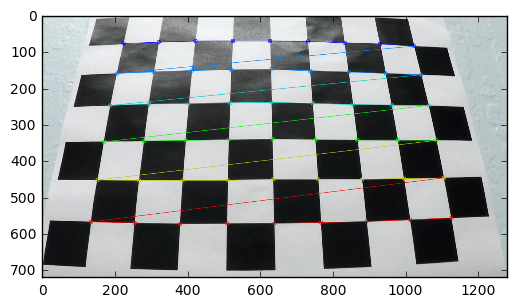

In [3]:
# this process creates the checkerboard points needed to 
# develop the calibration matrix

objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for path in checkerboard_file_list: 
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
#     print(ret, path)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)


# Undistort

In [4]:
#  this function generates the calibration matrix needed to undistort each future image from the camera

ret, mtx,dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Gradient thresholding functions


In [5]:
# the basic functions needed

# sobel , which thresholds for the magnitude of the gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    scaled_sobel_x = np.uint8(255*abs_sobel_x / np.max(abs_sobel_x))
    scaled_sobel_y = np.uint8(255*abs_sobel_y / np.max(abs_sobel_y))
    
   
    
    sx_binary = np.zeros_like(scaled_sobel_x)
    sx_binary[(scaled_sobel_x >= thresh[0]) & (scaled_sobel_x <= thresh[1])] = 1  
       
    sy_binary = np.zeros_like(scaled_sobel_y)
    sy_binary[(scaled_sobel_y >= thresh[0]) & (scaled_sobel_y <= thresh[1])] = 1  
    
    if orient == 'x': 
        return sx_binary
        
    if orient == 'y':
        return sy_binary
    
    
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 6) Create a binary mask where mag thresholds are met
    # 7) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # abs_sobel_x = np.absolute(sobel_x)
    # abs_sobel_y = np.absolute(sobel_y)
    
    # scaled_sobel_x = np.uint8(255*abs_sobel_x / np.max(abs_sobel_x))
    # scaled_sobel_y = np.uint8(255*abs_sobel_y / np.max(abs_sobel_y))
    
    magnitude = np.sqrt((sobel_x**2) + (sobel_y**2))
    scale_factor = np.max(magnitude)/255
    magnitude=  (magnitude/scale_factor).astype(np.uint8)
    
    mag_binary= np.zeros_like(magnitude)
    mag_binary[(magnitude >= mag_thresh[0]) & (magnitude <= mag_thresh[1])] = 1  
      
    # binary_output = np.copy(img) # Remove this line
    return mag_binary


# thresholding the direction 

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    # Here I'm suppressing annoying error messages
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# color thresholding function 
def hls_select(img, thresh=(0, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_output =  np.zeros_like(s)
    binary_output[(s >= thresh[0]) & (s <= thresh[1])] = 1
    return binary_output


In [6]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [7]:
# my image process
def process_image(image):
    original = np.copy(image)
    
    # Undistort the frame
    undistort = cv2.undistort(image, mtx, dist, None, mtx)
    
    # gradients and thresholds
    ksize = 3
    sobelx_binary = abs_sobel_thresh(undistort, orient='x', sobel_kernel=ksize, thresh=(20,100))
   
    # color thresholding
    s_binary = hls_select(image, thresh = (100,255))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(s_binary == 1) | (sobelx_binary == 1)] = 1

      
  
#     newwarp = find_lanes(combined_binary)
    
    # adding the lanes to the original
#     result = cv2.addWeighted(original, 1, newwarp, 0.3, 0) # this wanted the pre-pipeline image for some reason 
    
    
    return combined_binary

# perspective transform function

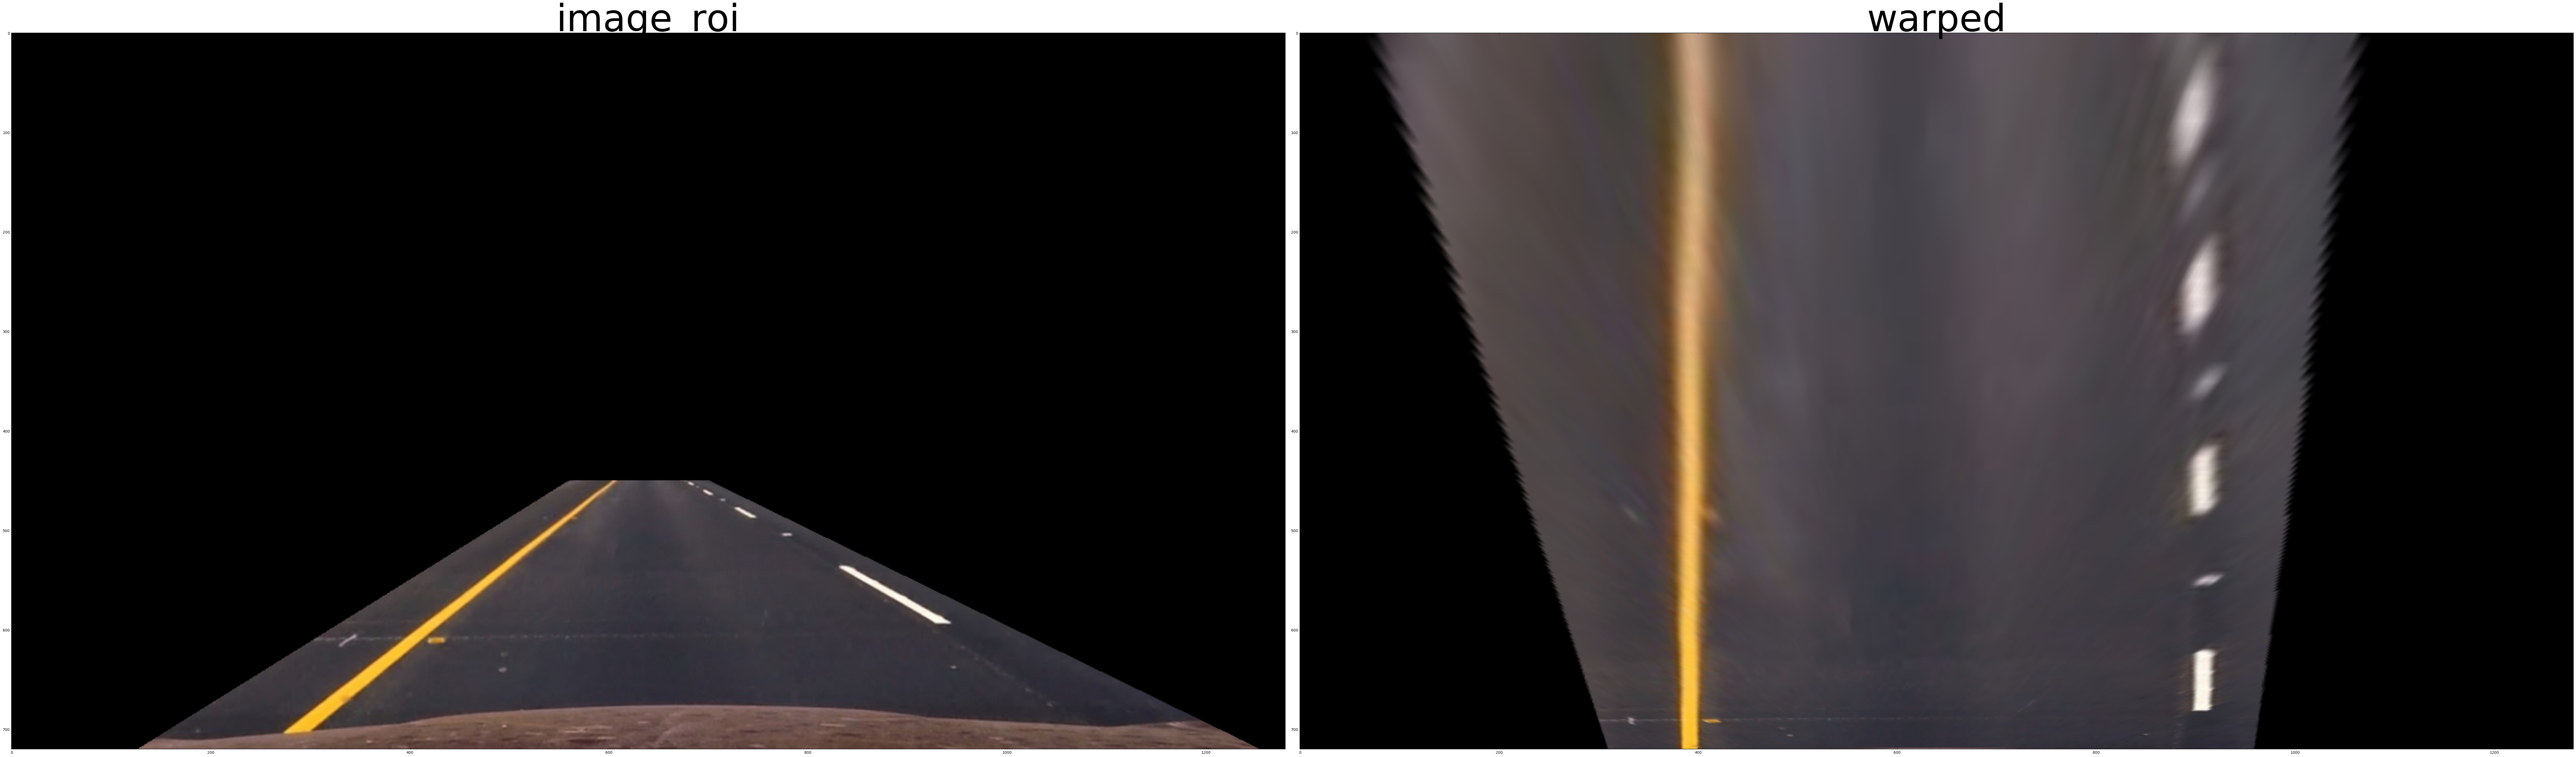

In [8]:
# this is a one time thing to get M and Minv , to be used on future images

# this is also masking the image in a trapezoid made by vertices below

img = mpimg.imread('/home/deep_cat/sdc-P4/test_images/test7.jpg')
img= cv2.undistort(img, mtx, dist, None, mtx)

vertices = np.array([[(127,720),(560, 450), (700,450), (1254,720)]], dtype=np.int32) # also this works without "dtype"
roi = region_of_interest(img, vertices)


img_size = (img.shape[1], img.shape[0])
x_offset = 400
y_offset =  0
 # manually picked points 
# src = np.float32([(570,480), (754, 480), (1084, 675), (310, 675)]) 
# src = np.float32([(604,450), (672,450), (1100,683), (330,683)])
# src = np.float32([(592,463), (697,463), (1054,680), (327,680)])
src = np.float32([(606,450), (675,450), (1054,680), (327,680)]) # did a little hand tuning here to make the projecton straight
dst = np.float32([[x_offset, y_offset], 
                  [img_size[0]-x_offset, y_offset], 
                  [img_size[0]-x_offset, img_size[1]-y_offset], 
                  [x_offset, img_size[1]-y_offset]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src) # used later to lay the the polynomials back into the image



warped = cv2.warpPerspective(roi, M, img_size)

    
font_size = 100
f, (ax1,ax2) = plt.subplots(1,2, figsize=(96,36))
f.tight_layout()
ax1.imshow(roi, cmap='gray')
ax1.set_title('image_roi', fontsize = font_size)
ax2.imshow(warped, cmap='gray')
ax2.set_title('warped', fontsize = font_size)



In [9]:
print(img_size[0], img_size[1])

1280 720


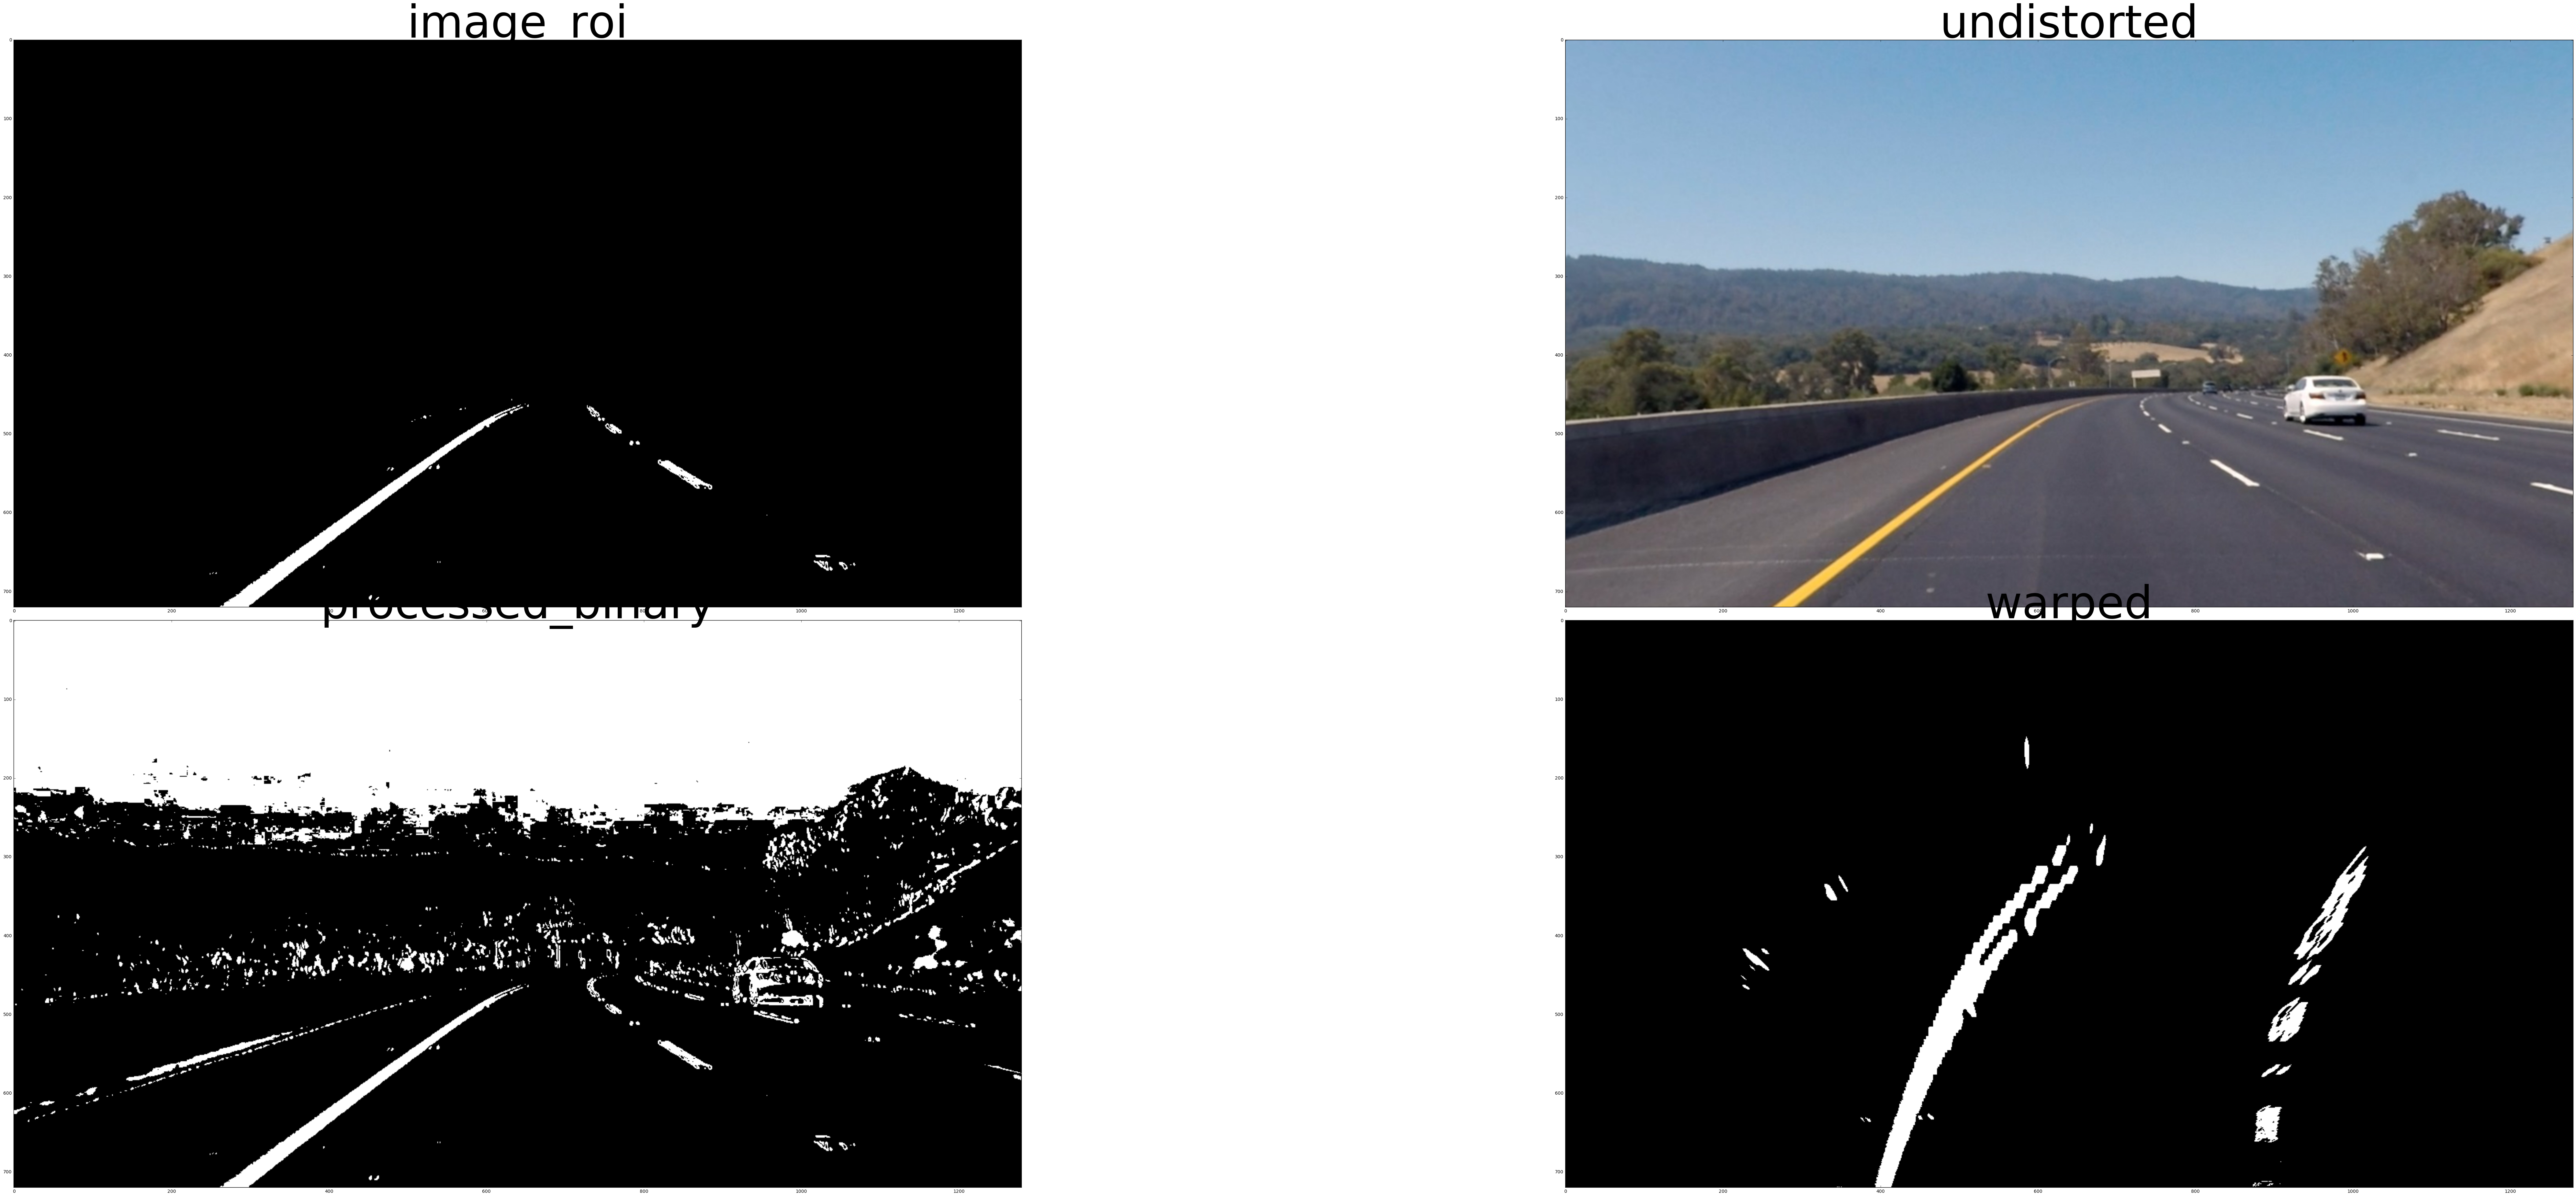

In [37]:
# testing on another test image
image = mpimg.imread('/home/deep_cat/sdc-P4/test_images/test3.jpg')

undistort= cv2.undistort(image, mtx, dist, None, mtx)
processed_binary = process_image(undistort)
roi = region_of_interest(processed_binary, vertices)



warped = cv2.warpPerspective(roi, M, img_size)




font_size = 100
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(96,36))
f.tight_layout()
ax1.imshow(roi, cmap='gray')
ax1.set_title('image_roi', fontsize = font_size)
ax2.imshow(undistort, cmap='gray')
ax2.set_title('undistorted', fontsize = font_size)
ax3.imshow(processed_binary, cmap='gray')
ax3.set_title('processed_binary', fontsize = font_size)
ax4.imshow(warped, cmap='gray')
ax4.set_title('warped', fontsize = font_size)


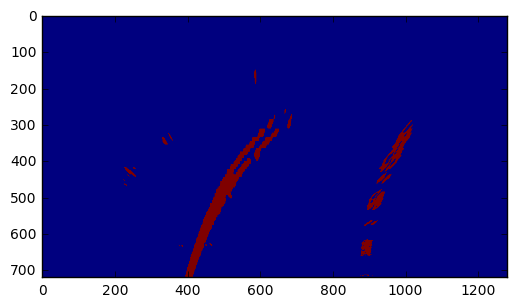

In [44]:
plt.imshow(warped)

# Creating the lines 


some notes from slack https://slack-files.com/T2HQV035L-F3QKKAXQR-ca50e716a7
guys i have to ask this question. This is for the sliding window part. So, for example if I get a window over say the left line of the image and do a histogram and get peaks to get the x coordinate, the values for the peaks are based on the window size. So if the image had 1000 pixels on the x axis and i was looking at a window of 200 pixels, the peak is in the middle at 100 which is in the window. how do i get the right x value?

Kyle Stewart-Frantz [10:38 AM] 
@ravindar Well when I scan the image for histogram, I first break up the image into left and right regions to find each sides respective x and y coordinates. Does that help?


ravindar gujral [10:51 AM] 
ok, that is interesting. so do you essentially break it down the middle and process each piece separately?

[10:52]  
@kylesf ^^

Kyle Stewart-Frantz [10:55 AM] 
Yes correct

Well I break the image into 20-30 segments and start at the bottom. Where the line origin is. Find max there and move on to next segment and only search in +- range of previous point found. @ravindar

ravindar gujral [11:09 AM] 
ok, how do you do the search in +- range of previous point found, do you use histogram method for that?

for i in reversed(range(10,100)):
            histogram = np.sum(img[i*img.shape[0]/100:(i+1)*img.shape[0]/100,img.shape[1]/2:], axis=0) 
            xcord = int(np.argmax(histogram)) + 640
            ycord = int(i*img.shape[0]/100)
            if (ycord == 0 or xcord == 0):
                pass
            elif (abs(xcord-past_cord) > 50 and not(i == 99) and not (past_cord == 0)):
                pass
            elif (xcord == (int(img.shape[1]/2))):
                pass
            else:
                right_side_x.append(xcord)
                right_side_y.append(ycord)
                past_cord = xcord
                
                ravindar gujral [11:17 AM] 
hmm ok so there is some hard coding with 640 here. ok thanks @kylesf. i am trying to do this without hardcoding a distance, i guess that is not possible

Kyle Stewart-Frantz [11:17 AM] 
then do int(myimage.shape[1]/2) (edited)

[11:18]  
instead of 640

[11:18]  
@ravindar I appended the code for you

ravindar gujral [11:20 AM] 
thanks @kylesf . so the question is where are your using the previous point found:
```            histogram = np.sum(img[i*img.shape[0]/100:(i+1)*img.shape[0]/100,img.shape[1]/2:], axis=0) 
            xcord = int(np.argmax(histogram)) + 640```
also the histogram is always half of the image, not around +- of the previous point found

Kyle Stewart-Frantz [11:20 AM] 
elif (abs(xcord-past_cord) > 50 and not(i == 99) and not (past_cord == 0)):

[11:21]  
if not in range it does not append

[11:21]  
That code is just the image histogram iteration direction sequence.

ravindar gujral [12:29 PM] 
ah got it

[12:30]  
thank you

In [38]:
# the code from above
# for i in reversed(range(10,100)):
#             histogram = np.sum(img[i*img.shape[0]/100:(i+1)*img.shape[0]/100,img.shape[1]/2:], axis=0) 
#             xcord = int(np.argmax(histogram)) + 640
#             ycord = int(i*img.shape[0]/100)
#             if (ycord == 0 or xcord == 0):
#                 pass
#             elif (abs(xcord-past_cord) > 50 and not(i == 99) and not (past_cord == 0)):
#                 pass
#             elif (xcord == (int(img.shape[1]/2))):
#                 pass
#             else:
#                 right_side_x.append(xcord)
#                 right_side_y.append(ycord)
#                 past_cord = xcord

/home/deep_cat/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


[484, 930]


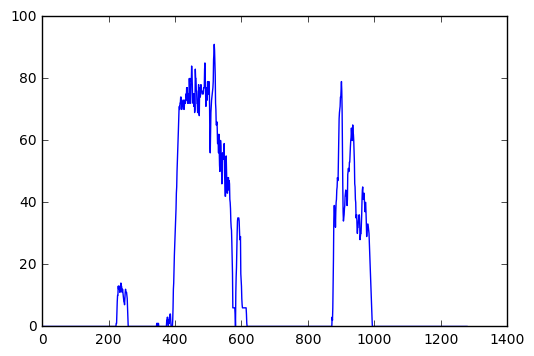

In [39]:
# this is a histogram of the lower half of the image 
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
peaks = signal.find_peaks_cwt(histogram, [100], min_length = 1,gap_thresh = 2, max_distances=[100])
plt.plot(histogram)
print(peaks)

In [40]:
batch = 120# 720 / 90  = 8 sliding window 
warped.shape[1]/2                                   
for i in range(int(warped.shape[0]/batch)):
    start = warped.shape[0] - (batch*(i+1))
    end = start + batch
    print(start,end)

600 720
480 600
360 480
240 360
120 240
0 120


In [55]:
# sliding window algorithm 
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
peaks = signal.find_peaks_cwt(histogram, [100], min_length = 1,gap_thresh = 2, max_distances=[100])

window_width = 50
batch = 40 # 720 / 90  = 8 sliding window 


left_coordinate = peaks[0]
right_coordinate = peaks[1]

left_xCoords = []
left_yCoords= []

right_xCoords = []
right_yCoords = []

draw_img = np.copy(warped)

for i in range(int(warped.shape[0]/batch)):
 
    ystart = warped.shape[0] - (batch*(i+1))
    yend = ystart + batch

    ############ for left window #############
    xstart = left_coordinate - window_width
    xend = left_coordinate + window_width

    left_window = warped[ystart:yend, xstart: xend] 


    l_histogram = np.sum(left_window, axis=0)
    l_peak = int(np.argmax(l_histogram))
    
    # adjust the peak location to the total image location
    left_xCoord = l_peak + xstart
    left_yCoord = (ystart + yend) / 2
    
    if l_peak == 0: 
        pass
    else:
        # append the new x and y locations to the list
        left_xCoords.append(left_xCoord)
        left_yCoords.append(left_yCoord)

        # update the left line coordinate so the window will move with the line
        left_coordinate = left_xCoord
    
    ############ for right window #############
    xstart_r = right_coordinate - window_width
    xend_r  = right_coordinate + window_width

    right_window = warped[ystart:yend, xstart_r: xend_r] 


    r_histogram = np.sum(right_window, axis=0)
    r_peak = int(np.argmax(r_histogram))
    
    # adjust the peak location to the total image location
    right_xCoord = r_peak + xstart_r
    right_yCoord = (ystart + yend) / 2
        
    if r_peak == 0: 
        pass
    else:
        # append the new x and y locations to the list
        right_xCoords.append(right_xCoord)
        right_yCoords.append(right_yCoord)
        
        # update the left line coordinate so the window will move with the line
        right_coordinate = right_xCoord
    
#     print(r_peak, xstart_r, right_xCoord)
    
    
    
print(left_xCoords, left_yCoords)
print(right_xCoords, right_yCoords)
    
    
    
    
    
    
    
    #     l_peak = (signal.find_peaks_cwt(l_histogram, [100], min_length = 1,gap_thresh = 2, max_distances=[100]))
    
#     if l_batch_peaks > 50:
#         left_center = xstart + batch_peaks
#     else:
#         left_center = xstart - batch_peaks
    
    
#     # for right window
#     xstart_right= right_center - window_width
#     xend_right = right_center + window_width

#     right_window = warped[ystart:yend, xstart_right: xend_right] 
#     r_histogram = np.sum(right_window, axis=0)
#     r_batch_peaks = np.mean(signal.find_peaks_cwt(r_histogram, [100], min_length = 1,gap_thresh = 2, max_distances=[100]))
#     if r_batch_peaks > 50:
#         right_center = xstart_right + batch_peaks
#     else: 
#         right_center = xstart_right - batch_peaks


#     print(left_center, right_center)

# plt.plot(r_histogram)
# plt.imshow(draw_img, cmap='gray')
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    # getting points related to left lane 
#     warped[630:720, 368:468]
    
#     for peak in batch_peaks:
#         if peak > last_peaks-100 and peak < last_peaks +100: 
#             left_window = warped[start:end, min(peaks)-window_width:min(peaks) + window_width]
#             cv2.rectangle(draw_img, box[0],box[1], color=(0, 0, 255), thick=6)
#             left_nonzero = cv2.findNonZero(left_window)
     
    
    
#     right_window = warped[start:end, max(peaks)-window_width:max(peaks) + window_width]
#     right_nonzero = cv2.findNonZero(right_window)
    
    

[445, 461, 478, 503, 526, 563, 606, 625, 667] [580.0, 540.0, 500.0, 460.0, 420.0, 380.0, 340.0, 300.0, 260.0]
[895, 892, 904, 895, 928, 935, 938, 965, 989, 1012] [660.0, 620.0, 580.0, 540.0, 500.0, 460.0, 420.0, 380.0, 340.0, 300.0]


/home/deep_cat/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [ ]:
plt.imshow(warped[630:720, 368:468])

In [ ]:
len(warped[630:720, 368:468])

In [ ]:
histogram = np.sum(warped[630:720, 368:468], axis=0)
batch_peaks = signal.find_peaks_cwt(histogram, [100], min_length = 1,gap_thresh = 2, max_distances=[100])
print(batch_peaks)

In [ ]:
nonzero = cv2.findNonZero(warped[630:720, 368:468])
nonzero.shape
# getting the x's (rows)


In [ ]:
nonzero2 = np.squeeze(nonzero)
nonzero2[:,0]
xvalues = nonzero2[:,0] + 368
yvalues = nonzero2[:,1] + 630
print(xvalues[0:10])
a = xvalues[:5]
b= xvalues[5:10]
np.concatenate((a, b), axis=0)

# Pipeline


In [ ]:
# image I want to use to test 
# image for calibrating the warping function
image = mpimg.imread('/home/deep_cat/sdc-P4/test_images/test4.jpg')
undistort = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(undistort)

In [ ]:
warped = cv2.warpPerspective(test4, M, img_size)
plt.imshow(warped)

In [ ]:
# finding the lanes
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
peaks = signal.find_peaks_cwt(histogram, [100], min_length = 1,gap_thresh = 2, max_distances=[100]) 
leftyvals = []
leftxvals = []
rightxvals = []
rightyvals = []
window_buffer = 50

left_lane_window = np.min(peaks)
right_lane_window = np.max(peaks)
for y in range(0, warped.shape[0]):
    for x in range(0, warped.shape[1]):
        pixel_value = warped[y,x]
        if x > left_lane_window - window_buffer and x < left_lane_window + window_buffer : 
            if pixel_value == 1:
                leftxvals.append(x)
                leftyvals.append(y)
        if x > right_lane_window - window_buffer and x < right_lane_window + window_buffer : 
            if pixel_value == 1:
                rightxvals.append(x)   
                rightyvals.append(y)


In [ ]:
# finding the polylines

leftyvals = np.asarray(leftyvals)
leftxvals = np.asarray(leftxvals)
rightyvals = np.asarray(rightyvals)
rightxvals = np.asarray(rightxvals)

# synthetic yvals to make it even
yvals = np.linspace(0, 100, num=101)*7.2

# for the left lane 
left_fit_coefficients = np.polyfit(leftyvals, leftxvals, 2) # creates the coeeficients
left_fitx = left_fit_coefficients[0] * yvals ** 2 + left_fit_coefficients[1] * yvals + left_fit_coefficients[2]

# for the right lane 
right_fit_coefficients = np.polyfit(rightyvals, rightxvals,2) # creates the coeeficients
right_fitx = right_fit_coefficients[0] * yvals ** 2 + right_fit_coefficients[1] * yvals + right_fit_coefficients[2]



In [ ]:
# drawing the polylines on original image

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 